In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# for interactive plots in notebook
%matplotlib inline

import scipy.integrate as integrate
import scipy.io as sio
#from Lorenz96_RK4 import Lorenz96
from L96_Model import L96
import sys, os, time, datetime
import pickle



In [16]:
# Data, Data Assimilation Hyperparameters
D = 20
Dobs = 12
dims = set(np.arange(20))
#dim_obs = [1, 2, 3, 5, 7, 9, 11, 13, 15, 17, 18, 19]
dim_obs = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 17, 18]
dim_unobs = list(dims - set(dim_obs))
M = 200

# Annealing Hyperparameters
Rm = float(1)
Rf0 = 1e8
alpha = 1.5
betamax = 1


# # Hamiltonian Monte Carlo Hyperparameters
# niter = int(1e3)
# Te = np.exp(1e-1*np.arange(niter))  # Temperature
# epsilon = 1e-3*np.ones(niter)
# L = 150
# mass = [1e2, 1e-2, 1e0]
# # Hamiltonian Monte Carlo Tuning Parameters
# mass_X = np.zeros(shape=(D,M))
# mass_X[dim_obs,:] = mass[0]
# mass_X[dim_unobs,:] = mass[1]
# mass_nu = mass[2]

# mass_X_sqrt = np.zeros(shape=(D,M))
# mass_X_sqrt[dim_obs,:] = np.sqrt(2*mass[0])
# mass_X_sqrt[dim_unobs,:] = np.sqrt(2*mass[1])
# mass_nu_sqrt = np.sqrt(2*mass[2])

# # Post-processing
# plot_Action_vs_beta = False
# savedata = False

In [17]:
# Load the data set
gen_nu = "8.17"
gen_noise = "sig0.4"
gen_dt = "0.001"
gen_delta_t = "0.025"
gen_integrator = "RK4"

# Specify the data path
datapath = ("./L96_D%s_nu%s_%s_dt%s_deltat%s_%s.mat" % 
    (str(D), gen_nu, gen_noise, gen_dt, gen_delta_t, gen_integrator))

if datapath[-3:] == "mat":
    datadict = sio.loadmat(datapath)
    data = datadict["Data"]
    dt = datadict["delta_t"][0]
elif datapath[-3:] == "npy":
    data = np.load(datapath)
else:
    raise IOError ("Does not recognize data file extension\n datapath = %s" % datapath)
    sys.exit()

In [18]:
# Prepare the data

Y = data[dim_obs,:M]

#Initialize the state variables
nu_init = 8

np.random.seed(12345)
X_init = np.zeros((D,M))
X_init[:,0] = 20*np.random.random(size=(D)) - 10
X_init[dim_obs, :] = Y

for k in range(0, M-1): 
    X_init[:,k+1] = X_init[:,k] + dt *  L96(X_init[:,k]+dt/2*L96(X_init[:,k], nu_init),nu_init)
    X_init[dim_obs,k+1] = Y[:,k+1]

In [19]:
# Initilize vectorized dirac delta functions
eyeDleft1 = np.roll(np.eye(D), -1, 1)
eyeDleft2 = np.roll(np.eye(D),-2,1)
eyeDright1 = np.roll(np.eye(D),1,1)
eyeD = np.eye(D)
# Some initializations for HMC

# Define the Rf ladder
# Rf = Rf0 * (alpha**(np.arange(0,betamax)))
Rf = Rf0 * 1.5**(35)

# Initialize the solutions
X_sol = X_init
nu_sol = nu_init
# Initialize the final output cell array. (It is a dict in order to replicate the cells data type in MATLAB)
# This will contain the final X_sol for each beta, and nu_sol for eah beta
q_min = {'X_min': np.zeros(shape=(D,M,betamax)), 'nu_min': np.zeros(shape=(betamax))}

#Initialize action matrix
# Action = np.zeros(shape=(betamax, niter))  #in MATLAB code, the shape is (betamax, niter+1). Not sure why the +1
Action_min = np.zeros(shape=(betamax,1))

# Percentage acceptance and percentage downhill
Acceptance = np.zeros(shape=(betamax,1))
Downhill = np.zeros(shape=(betamax, 1))

# Initialize Momentum
pX0 = np.zeros(shape=(D,M))

In [20]:
def fun_A(X, Xleft1, hX, Y, dim_obs, M, Rm, Rf):
    kern1 = Rm/(2*M) * np.sum((X[dim_obs,:] - Y)**2)
    
    kern2 = Xleft1 - hX
    kern2 = Rf/(2*M) * np.sum(kern2[:,:M-1]**2) # Is this right? I feel like it's leaving out one column
    
    
    return kern1 + kern2

In [21]:
def fun_getPieces(X, nu, dt):
    Xup1 = np.roll(X, -1, 0)
    Xdown1 = np.roll(X, 1, 0)
    Xdown2 = np.roll(X, 2, 0)
    Xleft1 = np.roll(X, -1, 1)
    
    Z = X + dt/2* (np.multiply(Xup1 - Xdown2, Xdown1) - X + nu)
    Zup1 = np.roll(Z, -1, 0)
    Zdown1 = np.roll(Z, 1, 0)
    Zdown2 = np.roll(Z, 2, 0)
    
    hX = X + dt * (np.multiply(Zup1 - Zdown2, Zdown1) - Z + nu)
    
    return Xup1, Xdown2, Xdown1, Xleft1, Zup1, Zdown2, Zdown1, hX

In [22]:
def Action_Wrapper(X, nu):
    Xup1, Xdown2, Xdown1, Xleft1, Zup1, Zdown2, Zdown1, hX = fun_getPieces(X, nu, dt)
    Action = fun_A(X, Xleft1, hX, Y, dim_obs, M, Rm, Rf)
    return Action


In [23]:
X_test = np.copy(X_init)
# X_test[0,:] += np.random.normal(0,1,size=(X_test.shape[1])) 
Xi = np.arange(-20,20,0.5)
Yj = np.arange(-20,20,0.5)
Z_action = np.zeros(shape=(len(Xi), len(Yj)))
nu = 8.17

for i in xrange(len(Xi)):
    for j in xrange(len(Yj)):
        X_init[0,0] = Xi[i]
        X_init[1,0] = Yj[j]
        Z_action[i,j] = Action_Wrapper(X_init, nu)

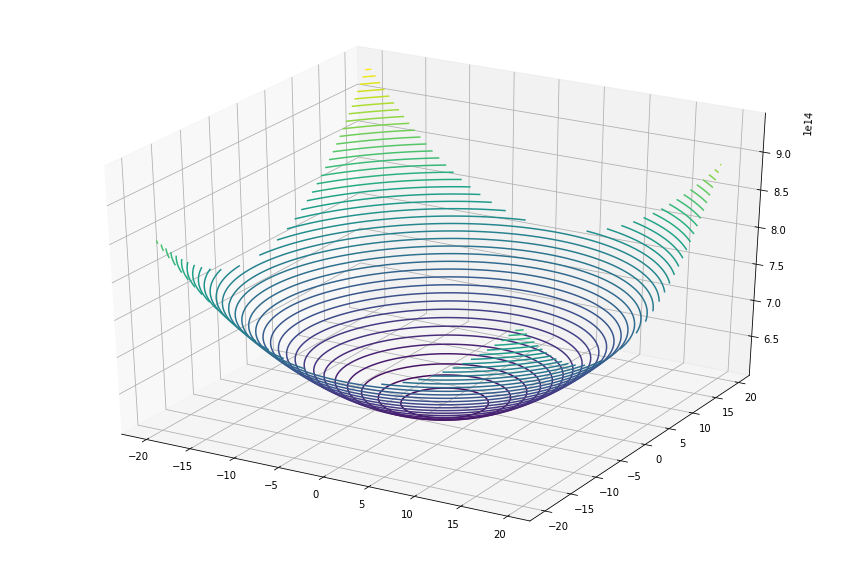

In [24]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(Xi, Yj)
# ax.plot_surface(X,Y, Z_action, cmap='viridis')
ax.contour3D(X,Y,Z_action, 50)

In [25]:
print(Rf)

1.45610960605e+14
